### Basic Imports

In [11]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
import numpy as np
from sklearn.model_selection import train_test_split
import pandas as pd
import matplotlib.pyplot as plt

### 数据预处理

In [2]:
# 加载数据集
ratings = pd.read_csv('/openbayes/input/input0/ratings.dat', sep='::', names=['userId', 'movieId', 'rating', 'timestamp'], engine='python')

# 去除缺失值
ratings.dropna(inplace=True)

# 检查数据集中是否有异常值
print(ratings['userId'].nunique(), ratings['movieId'].nunique())
ratings.head(5)

6040 3706


,userId,movieId,rating,timestamp
0,1,1193,5,978300760
1,1,661,3,978302109
2,1,914,3,978301968
3,1,3408,4,978300275
4,1,2355,5,978824291


In [3]:
# 创建用户和项目ID的映射
unique_user_ids = ratings['userId'].unique()
unique_item_ids = ratings['movieId'].unique()
user_id_map = {id: i for i, id in enumerate(unique_user_ids)}
item_id_map = {id: i for i, id in enumerate(unique_item_ids)}

# 映射用户和项目ID
ratings['userId'] = ratings['userId'].map(user_id_map)
ratings['movieId'] = ratings['movieId'].map(item_id_map)

# 检查是否有映射失败的ID
print(ratings['userId'].isna().sum(), ratings['movieId'].isna().sum())

0 0


In [4]:
# 去除映射失败的ID
ratings.dropna(subset=['userId', 'movieId'], inplace=True)
ratings['userId'] = ratings['userId'].astype(int)
ratings['movieId'] = ratings['movieId'].astype(int)

In [5]:
# 创建用户-物品对和标签
user_item_pairs = list(zip(ratings['userId'], ratings['movieId']))
labels = (ratings['rating'] >= 4).astype(int)  # 评分>=4视为正样本

# 划分训练集和测试集
train_pairs, test_pairs, train_labels, test_labels = train_test_split(user_item_pairs, labels, test_size=0.2, random_state=42)
# 定义数据集类
class MovieLensDataset(Dataset):
    def __init__(self, user_item_pairs, labels):
        self.user_item_pairs = user_item_pairs
        self.labels = labels

    def __len__(self):
        return len(self.user_item_pairs)

    def __getitem__(self, idx):
        user, item = self.user_item_pairs[idx]
        label = self.labels.iloc[idx]  # 这里使用iloc确保按行号索引
        return torch.tensor(user, dtype=torch.long), torch.tensor(item, dtype=torch.long), torch.tensor(label, dtype=torch.float)

# 创建数据加载器
train_dataset = MovieLensDataset(train_pairs, train_labels)
test_dataset = MovieLensDataset(test_pairs, test_labels)
train_dataloader = DataLoader(train_dataset, batch_size=256, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=256, shuffle=False)

### 实现三种方法（GMF, MLP, NeuMF）

In [6]:
# 模型定义
class GMF(nn.Module):
    def __init__(self, num_users, num_items, latent_dim):
        super(GMF, self).__init__()
        self.user_embedding = nn.Embedding(num_users, latent_dim)
        self.item_embedding = nn.Embedding(num_items, latent_dim)
        self.output = nn.Linear(latent_dim, 1)
    
    def forward(self, user, item):
        user_latent = self.user_embedding(user)
        item_latent = self.item_embedding(item)
        element_product = torch.mul(user_latent, item_latent)
        output = self.output(element_product)
        return torch.sigmoid(output)

class MLP(nn.Module):
    def __init__(self, num_users, num_items, latent_dim, layers):
        super(MLP, self).__init__()
        self.user_embedding = nn.Embedding(num_users, latent_dim)
        self.item_embedding = nn.Embedding(num_items, latent_dim)
        self.layers = nn.Sequential()
        input_dim = latent_dim * 2
        for layer in layers:
            self.layers.add_module(f"layer_{layer}", nn.Linear(input_dim, layer))
            self.layers.add_module(f"relu_{layer}", nn.ReLU())
            input_dim = layer
        self.output = nn.Linear(input_dim, 1)
    
    def forward(self, user, item):
        user_latent = self.user_embedding(user)
        item_latent = self.item_embedding(item)
        concatenated = torch.cat([user_latent, item_latent], dim=-1)
        x = self.layers(concatenated)
        output = self.output(x)
        return torch.sigmoid(output)

class NeuMF(nn.Module):
    def __init__(self, num_users, num_items, latent_dim_gmf, latent_dim_mlp, layers):
        super(NeuMF, self).__init__()
        self.gmf_user_embedding = nn.Embedding(num_users, latent_dim_gmf)
        self.gmf_item_embedding = nn.Embedding(num_items, latent_dim_gmf)
        self.mlp_user_embedding = nn.Embedding(num_users, latent_dim_mlp)
        self.mlp_item_embedding = nn.Embedding(num_items, latent_dim_mlp)
        
        self.mlp_layers = nn.Sequential()
        input_dim = latent_dim_mlp * 2
        for layer in layers:
            self.mlp_layers.add_module(f"layer_{layer}", nn.Linear(input_dim, layer))
            self.mlp_layers.add_module(f"relu_{layer}", nn.ReLU())
            input_dim = layer
        
        self.output = nn.Linear(latent_dim_gmf + layers[-1], 1)
    
    def forward(self, user, item):
        gmf_user_latent = self.gmf_user_embedding(user)
        gmf_item_latent = self.gmf_item_embedding(item)
        gmf_output = torch.mul(gmf_user_latent, gmf_item_latent)
        
        mlp_user_latent = self.mlp_user_embedding(user)
        mlp_item_latent = self.mlp_item_embedding(item)
        concatenated = torch.cat([mlp_user_latent, mlp_item_latent], dim=-1)
        mlp_output = self.mlp_layers(concatenated)
        
        final_output = torch.cat([gmf_output, mlp_output], dim=-1)
        output = self.output(final_output)
        return torch.sigmoid(output)


### 定义训练

In [7]:
# 训练和测试函数
def train(model, dataloader, criterion, optimizer, device):
    model.train()
    total_loss = 0
    for user, item, label in dataloader:
        user, item, label = user.to(device), item.to(device), label.to(device)
        optimizer.zero_grad()
        prediction = model(user, item)
        loss = criterion(prediction, label.unsqueeze(1))
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    return total_loss / len(dataloader)

def hit_rate(predictions, labels, top_k=10):
    k = min(top_k, predictions.size(0))  # 确保 k 不超过 predictions 的大小
    if k == 0:
        return 0.0
    _, top_k_indices = torch.topk(predictions, k)
    hit = labels[top_k_indices].sum().item()
    return hit / len(labels)

def ndcg(predictions, labels, top_k=10):
    k = min(top_k, predictions.size(0))  # 确保 k 不超过 predictions 的大小
    if k == 0:
        return 0.0
    _, top_k_indices = torch.topk(predictions, k)
    device = predictions.device  # 获取当前设备
    gain = labels[top_k_indices].float().to(device) / torch.log2(torch.arange(2, k + 2).float().to(device))
    return gain.sum().item() / len(labels)

def test(model, dataloader, device, top_k=10):
    model.eval()
    HR, NDCG = [], []
    with torch.no_grad():
        for user, item, label in dataloader:
            user, item, label = user.to(device), item.to(device), label.to(device)
            prediction = model(user, item)
            HR.append(hit_rate(prediction.squeeze().to(device), label.to(device), top_k))  # 确保所有张量在同一设备上
            NDCG.append(ndcg(prediction.squeeze().to(device), label.to(device), top_k))  # 确保所有张量在同一设备上
    return np.mean(HR), np.mean(NDCG)

### 比较三种方法

In [8]:
# 设置超参数
num_users = ratings['userId'].nunique()  # 6040
num_items = ratings['movieId'].nunique()  # 3706
latent_dim_gmf = 8
latent_dim_mlp = 8
layers = [64, 32, 16, 8]
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# 创建模型实例
gmf_model = GMF(num_users, num_items, latent_dim_gmf).to(device)
mlp_model = MLP(num_users, num_items, latent_dim_mlp, layers).to(device)
neumf_model = NeuMF(num_users, num_items, latent_dim_gmf, latent_dim_mlp, layers).to(device)

# 定义损失函数和优化器
criterion = nn.BCELoss()
gmf_optimizer = optim.Adam(gmf_model.parameters(), lr=0.001)
mlp_optimizer = optim.Adam(mlp_model.parameters(), lr=0.001)
neumf_optimizer = optim.Adam(neumf_model.parameters(), lr=0.001)

In [9]:
num_epochs = 10

gmf_train_losses, gmf_hr_list, gmf_ndcg_list = [], [], []
mlp_train_losses, mlp_hr_list, mlp_ndcg_list = [], [], []
neumf_train_losses, neumf_hr_list, neumf_ndcg_list = [], [], []

for epoch in range(num_epochs):
    gmf_train_loss = train(gmf_model, train_dataloader, criterion, gmf_optimizer, device)
    gmf_hr, gmf_ndcg = test(gmf_model, test_dataloader, device)
    gmf_train_losses.append(gmf_train_loss)
    gmf_hr_list.append(gmf_hr)
    gmf_ndcg_list.append(gmf_ndcg)
    
    mlp_train_loss = train(mlp_model, train_dataloader, criterion, mlp_optimizer, device)
    mlp_hr, mlp_ndcg = test(mlp_model, test_dataloader, device)
    mlp_train_losses.append(mlp_train_loss)
    mlp_hr_list.append(mlp_hr)
    mlp_ndcg_list.append(mlp_ndcg)
    
    neumf_train_loss = train(neumf_model, train_dataloader, criterion, neumf_optimizer, device)
    neumf_hr, neumf_ndcg = test(neumf_model, test_dataloader, device)
    neumf_train_losses.append(neumf_train_loss)
    neumf_hr_list.append(neumf_hr)
    neumf_ndcg_list.append(neumf_ndcg)
    
    print(f"Epoch {epoch+1}/{num_epochs}")
    print(f"GMF: HR@10 = {gmf_hr:.4f}, NDCG@10 = {gmf_ndcg:.4f}")
    print(f"MLP: HR@10 = {mlp_hr:.4f}, NDCG@10 = {mlp_ndcg:.4f}")
    print(f"NeuMF: HR@10 = {neumf_hr:.4f}, NDCG@10 = {neumf_ndcg:.4f}")

Epoch 1/10
GMF: HR@10 = 0.0225, NDCG@10 = 0.0102
MLP: HR@10 = 0.0349, NDCG@10 = 0.0159
NeuMF: HR@10 = 0.0351, NDCG@10 = 0.0160
Epoch 2/10
GMF: HR@10 = 0.0225, NDCG@10 = 0.0101
MLP: HR@10 = 0.0360, NDCG@10 = 0.0165
NeuMF: HR@10 = 0.0360, NDCG@10 = 0.0164
Epoch 3/10
GMF: HR@10 = 0.0224, NDCG@10 = 0.0101
MLP: HR@10 = 0.0364, NDCG@10 = 0.0166
NeuMF: HR@10 = 0.0365, NDCG@10 = 0.0166
Epoch 4/10
GMF: HR@10 = 0.0218, NDCG@10 = 0.0099
MLP: HR@10 = 0.0366, NDCG@10 = 0.0167
NeuMF: HR@10 = 0.0366, NDCG@10 = 0.0167
Epoch 5/10
GMF: HR@10 = 0.0214, NDCG@10 = 0.0097
MLP: HR@10 = 0.0367, NDCG@10 = 0.0167
NeuMF: HR@10 = 0.0366, NDCG@10 = 0.0167
Epoch 6/10
GMF: HR@10 = 0.0219, NDCG@10 = 0.0099
MLP: HR@10 = 0.0367, NDCG@10 = 0.0168
NeuMF: HR@10 = 0.0367, NDCG@10 = 0.0167
Epoch 7/10
GMF: HR@10 = 0.0228, NDCG@10 = 0.0103
MLP: HR@10 = 0.0366, NDCG@10 = 0.0167
NeuMF: HR@10 = 0.0366, NDCG@10 = 0.0167
Epoch 8/10
GMF: HR@10 = 0.0245, NDCG@10 = 0.0111
MLP: HR@10 = 0.0367, NDCG@10 = 0.0168
NeuMF: HR@10 = 0.0366, N

### 绘图

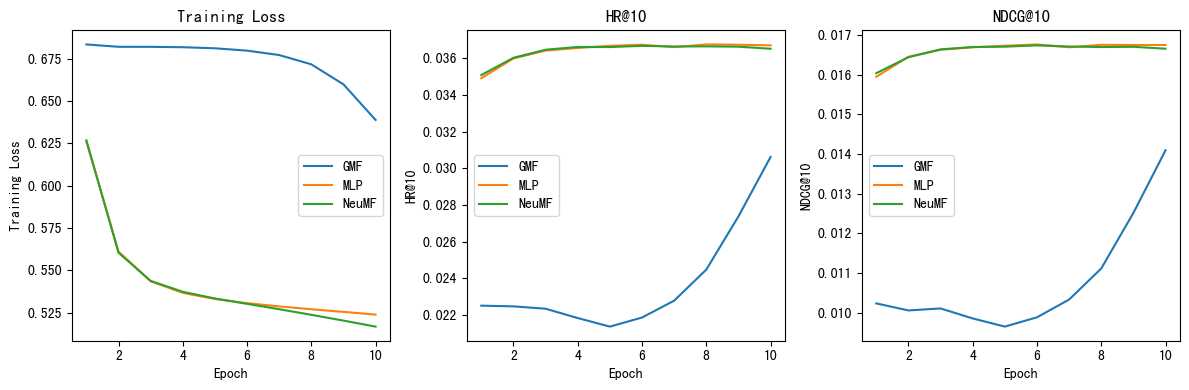

In [12]:
# 绘制训练损失图
plt.figure(figsize=(12, 4))
plt.subplot(1, 3, 1)
plt.plot(range(1, num_epochs + 1), gmf_train_losses, label='GMF')
plt.plot(range(1, num_epochs + 1), mlp_train_losses, label='MLP')
plt.plot(range(1, num_epochs + 1), neumf_train_losses, label='NeuMF')
plt.xlabel('Epoch')
plt.ylabel('Training Loss')
plt.legend()
plt.title('Training Loss')

# 绘制HR@10图
plt.subplot(1, 3, 2)
plt.plot(range(1, num_epochs + 1), gmf_hr_list, label='GMF')
plt.plot(range(1, num_epochs + 1), mlp_hr_list, label='MLP')
plt.plot(range(1, num_epochs + 1), neumf_hr_list, label='NeuMF')
plt.xlabel('Epoch')
plt.ylabel('HR@10')
plt.legend()
plt.title('HR@10')

# 绘制NDCG@10图
plt.subplot(1, 3, 3)
plt.plot(range(1, num_epochs + 1), gmf_ndcg_list, label='GMF')
plt.plot(range(1, num_epochs + 1), mlp_ndcg_list, label='MLP')
plt.plot(range(1, num_epochs + 1), neumf_ndcg_list, label='NeuMF')
plt.xlabel('Epoch')
plt.ylabel('NDCG@10')
plt.legend()
plt.title('NDCG@10')

plt.tight_layout()
plt.show()

### 消融实验

#### 定义不同层数的MLP模型

In [15]:
class MLP(nn.Module):
    def __init__(self, num_users, num_items, latent_dim, layers):
        super(MLP, self).__init__()
        self.user_embedding = nn.Embedding(num_users, latent_dim)
        self.item_embedding = nn.Embedding(num_items, latent_dim)
        self.layers = nn.Sequential()
        input_dim = latent_dim * 2
        for layer in layers:
            self.layers.add_module(f"layer_{layer}", nn.Linear(input_dim, layer))
            self.layers.add_module(f"relu_{layer}", nn.ReLU())
            input_dim = layer
        self.output = nn.Linear(input_dim, 1)
    
    def forward(self, user, item):
        user_latent = self.user_embedding(user)
        item_latent = self.item_embedding(item)
        concatenated = torch.cat([user_latent, item_latent], dim=-1)
        x = self.layers(concatenated)
        output = self.output(x)
        return torch.sigmoid(output)


In [16]:
def ndcg_score(predictions, labels, top_k=10):
    k = min(top_k, predictions.size(0))  # 确保 k 不超过 predictions 的大小
    if k == 0:
        return 0.0
    _, top_k_indices = torch.topk(predictions, k)
    device = predictions.device  # 获取当前设备
    gain = labels[top_k_indices].float().to(device) / torch.log2(torch.arange(2, k + 2).float().to(device))
    return gain.sum().item() / len(labels)


In [17]:
def test(model, dataloader, device, top_k=10):
    model.eval()
    HR, NDCG = [], []
    with torch.no_grad():
        for user, item, label in dataloader:
            user, item, label = user.to(device), item.to(device), label.to(device)
            prediction = model(user, item)
            HR.append(hit_rate(prediction.squeeze().to(device), label.to(device), top_k))  # 确保所有张量在同一设备上
            NDCG.append(ndcg_score(prediction.squeeze().to(device), label.to(device), top_k))  # 确保所有张量在同一设备上
    return np.mean(HR), np.mean(NDCG)


#### 修改层数进行消融研究

In [18]:
# 定义不同层数的MLP模型
layer_configs = {
    'MLP-0': [],
    'MLP-1': [64],
    'MLP-2': [64, 32],
    'MLP-3': [64, 32, 16],
    'MLP-4': [64, 32, 16, 8]
}

results = {}

for config_name, layers in layer_configs.items():
    print(f"Training {config_name}...")
    model = MLP(num_users, num_items, latent_dim_mlp, layers).to(device)
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    train_loss = train(model, train_dataloader, criterion, optimizer, device)
    hr, ndcg_val = test(model, test_dataloader, device)
    results[config_name] = hr
    print(f"{config_name}: HR@10 = {hr:.4f}")

# 打印结果
for config_name, hr in results.items():
    print(f"{config_name}: HR@10 = {hr:.4f}")


Training MLP-0...
MLP-0: HR@10 = 0.0347
Training MLP-1...
MLP-1: HR@10 = 0.0350
Training MLP-2...
MLP-2: HR@10 = 0.0350
Training MLP-3...
MLP-3: HR@10 = 0.0350
Training MLP-4...
MLP-4: HR@10 = 0.0347
MLP-0: HR@10 = 0.0347
MLP-1: HR@10 = 0.0350
MLP-2: HR@10 = 0.0350
MLP-3: HR@10 = 0.0350
MLP-4: HR@10 = 0.0347
